In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.25)
%matplotlib inline

## Section 1: Load and prepare data

#### 1.1 Load Data

In [2]:
from pandas import read_csv

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
data = read_csv(os.path.join('data','bennett2020.csv'))

## Reformat columns.
f = lambda x: np.arange(x.size) + 1
data['stimulus_type'] = data.stimulus_type.replace({'GW':0, 'NGW':1, 'GAL':2, 'NGAL':3})
data['block'] = np.where(data['block'] < 4, 1, 2)
data['exposure'] = data.groupby(['id','block','stimulus_type']).trial.transform(f)

## Restrict to participants with GW accuracy > 0.5.
gb = data.query('stimulus_type==0').groupby('id').correct.mean()
data = data[data.id.isin(gb[gb>0.5].index)]

#### 1.2 Practice Effects

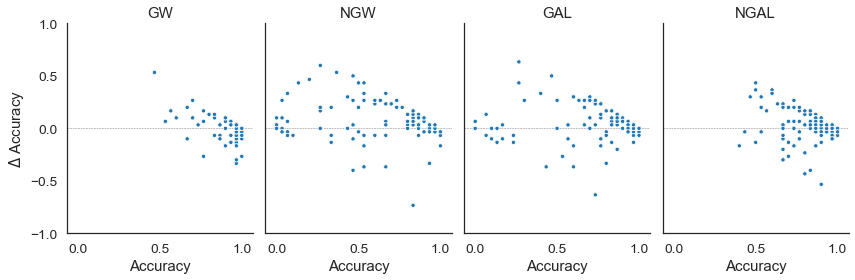

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Groupby participant/block/stumulus. 
pivot = data.groupby(['id','block','stimulus_type']).correct.mean().reset_index()

## Make pivot table.
pivot = pivot.pivot_table('correct',['block','id'],'stimulus_type')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(12,4),sharex=True,sharey=True)

for i, (ax, title) in enumerate(zip(axes,['GW','NGW','GAL','NGAL'])):
    
    ## Plot change in accuracy by initial accuracy.
    sns.scatterplot(pivot.loc[1,i], pivot.loc[2,i] - pivot.loc[1,i], 
                    size=15, ax=ax)
    ax.axhline(0, lw=0.5, linestyle='--', color='0.5', zorder=-1)
    
    ## Add details.
    ax.set(xlabel='Accuracy', ylim=(-1,1), title=title)
    if not i: ax.set_ylabel(r'$\Delta$ Accuracy')
    ax.legend_.set_visible(False)
    
sns.despine()
plt.tight_layout()

## Section 2: Model-agnostic analysis

#### 2.1 Parameter-behavior correlations

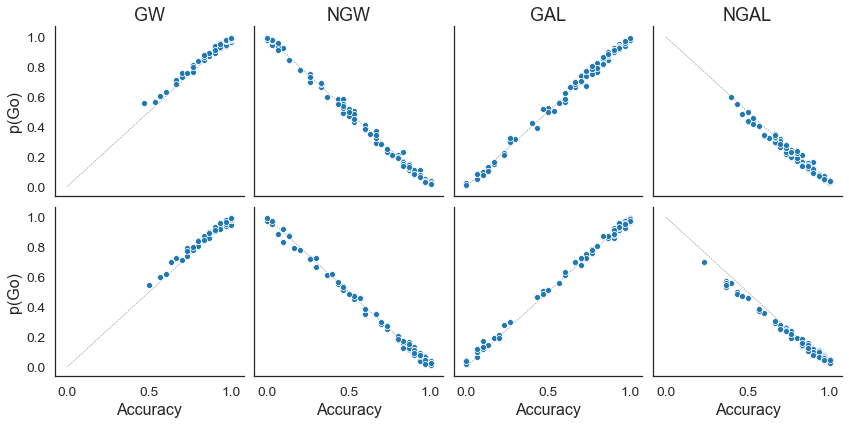

In [4]:
from notorious.io import load_fit
from notorious.posterior import inv_logit

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define metadata.
stan_model = 'logistic_trt'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load StanFit.
samples = load_fit(os.path.join('stan_results',f'{stan_model}.pkl'))

## Extract coefficients.
beta = inv_logit(np.median(samples['beta'], axis=0))

## Compute groupby.
pivot = data.groupby(['id','block','stimulus_type']).correct.mean().reset_index()
pivot = pivot.pivot_table('correct',('block','id'),'stimulus_type')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(2,4,figsize=(12,6),sharex=True,sharey=True)

## Iteratively plot.
for i, block in enumerate([1,2]):
    
    for j, title in enumerate(['GW','NGW','GAL','NGAL']):
        
        ## Plot parameters by accuracy.
        sns.scatterplot(pivot.loc[block,j], beta[:,i,j], ax=axes[i,j])
        axes[i,j].plot([0,1], np.roll([0,1],j), lw=0.5, linestyle='--', color='0.5', zorder=-1)
        
        ## Add details.
        if i: axes[i,j].set_xlabel('Accuracy', fontsize=16)
        else: axes[i,j].set_title(title, fontsize=18)
        if not j: axes[i,j].set_ylabel('p(Go)', fontsize=16)
            
sns.despine()
plt.tight_layout()

#### 2.2 Test-retest coefficients

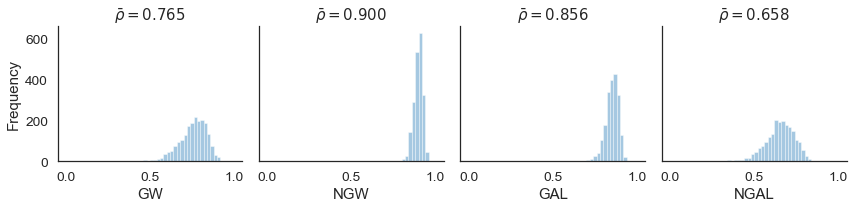

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract test-retest coefficients.
rho = samples['rho']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(12,3),sharex=True,sharey=True)

## Iteratively plot.
for i, (ax, title) in enumerate(zip(axes, ['GW','NGW','GAL','NGAL'])):
    
    ## Plot coefficients.
    sns.distplot(rho[:,i], kde=False, bins=np.linspace(0,1,51), ax=ax)
    
    ## Add details.
    ax.set(xlabel=title, title=r'$\bar{\rho} = %0.3f$' %np.median(rho[:,i]))
    if not i: ax.set_ylabel('Frequency')
    
sns.despine()
plt.tight_layout()

## Section 3: Model-based analysis

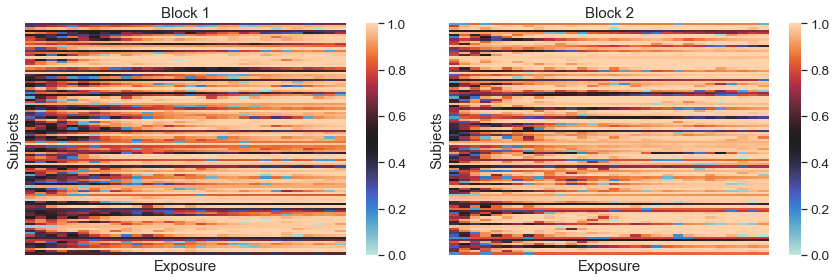

In [6]:
from notorious.io import load_fit
from notorious.posterior import posterior_predictive_pit

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define metadata.
stan_model = 'pit_trt_m1'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4))
sort_ix = data.groupby('id').correct.mean().argsort()[::-1].values

for i, ax in enumerate(axes):

    ## Load StanFit.
    samples = load_fit(os.path.join('stan_results', f'{stan_model}.pkl'))
    
    ## Extract parameters.
    samples = dict(beta = samples['beta'][:,i], eta = samples['eta'][:,i],
                   tau = samples['tau'][:,i], nu = samples['nu'][:,i], 
                   lp__ = samples['lp__'], H = samples['H'], T = samples['T'],
                   Y = samples['Y'][i], R = samples['R'][i], 
                   sub_ix = samples['sub_ix'], pav_ix = samples['pav_ix'])

    ## Compute log-likelihood.
    log_lik = posterior_predictive_pit(samples)
    
    ## Plot likelihoods.
    arr = np.median(np.exp(log_lik), axis=0).T
    sns.heatmap(arr[sort_ix], vmin=0, vmax=1, center=0.5, xticklabels=[], yticklabels=[], ax=ax)
    
    ## Add detail.
    ax.set(xlabel='Exposure', ylabel='Subjects', title=f'Block {i+1}')
    
plt.tight_layout()

#### 2.2 Parameter-behavior correlations

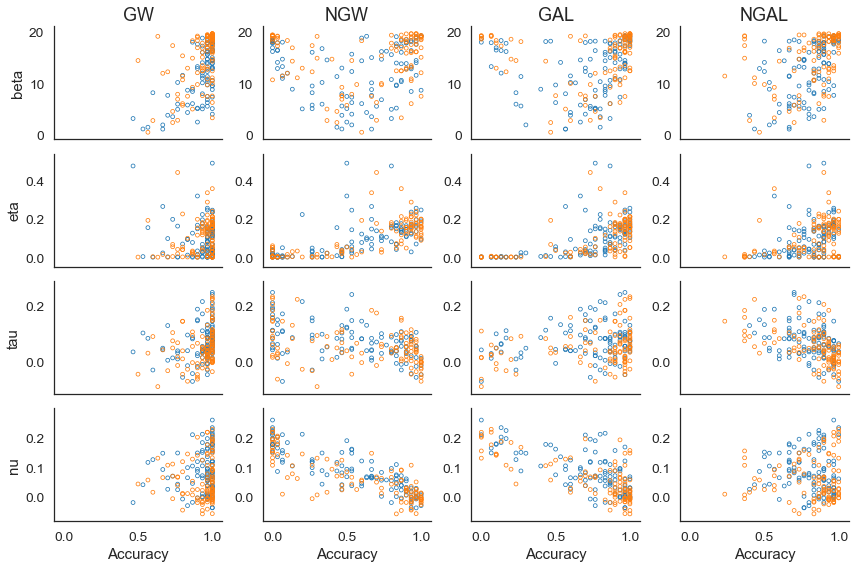

In [7]:
from notorious.io import load_fit

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define metadata.
stan_model = 'pit_trt_m1'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load StanFit.
samples = load_fit(os.path.join('stan_results',f'{stan_model}.pkl'))

## Extract parameters.
beta = np.median(samples['beta'], axis=0)
eta  = np.median(samples['eta'], axis=0)
tau  = np.median(samples['tau'], axis=0)
nu   = np.median(samples['nu'], axis=0)

## Compute groupby.
pivot = data.groupby(['id','block','stimulus_type']).correct.mean().reset_index()
pivot = pivot.pivot_table('correct',('block','id'),'stimulus_type')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(4,4,figsize=(12,8),sharex=True)
ylims = [(0,20),(-0.05,1.05),(-0.4,0.4),(-0.4,0.4)]

for i, (arr, par) in enumerate(zip([beta,eta,tau,nu], ['beta','eta','tau','nu'])):

    for j, stim in enumerate(['GW','NGW','GAL','NGAL']):
        
        ## Plot behavior-parameter correlations.
        sns.scatterplot(pivot.loc[1,j], arr[0], s=15, color='none', edgecolor='#1f77b4', ax=axes[i,j])
        sns.scatterplot(pivot.loc[2,j], arr[1], s=15, color='none', edgecolor='#ff7f0e', ax=axes[i,j])

        ## Add details.
        # axes[i,j].set_ylim(*ylims[j])
        if not i: axes[i,j].set_title(stim, fontsize=18)
        if not j: axes[i,j].set_ylabel(par)
        if i == 3: axes[i,j].set_xlabel('Accuracy')
            
sns.despine()
plt.tight_layout()

#### 3.3 Test-retest coefficients

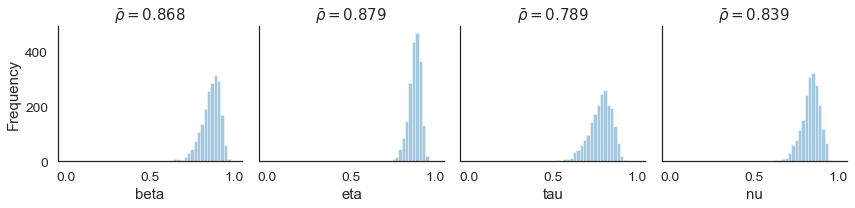

In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract test-retest coefficients.
rho = samples['rho']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(12,3),sharex=True,sharey=True)

## Iteratively plot.
for i, (ax, title) in enumerate(zip(axes, ['beta','eta','tau','nu'])):
    
    ## Plot coefficients.
    sns.distplot(rho[:,i], kde=False, bins=np.linspace(0,1,51), ax=ax)
    
    ## Add details.
    ax.set(xlabel=title, title=r'$\bar{\rho} = %0.3f$' %np.median(rho[:,i]))
    if not i: ax.set_ylabel('Frequency')
    
sns.despine()
plt.tight_layout()